# 0. Importing Packages

In [51]:
import altair as alt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import pandas as pd
from osgeo import gdal as gd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 500)


## 1. Introduction

In this project, we will use a data set on AirBnB listings in Amsterdam to predict listing prices. The challenge lies in the fact that the dataset only includes a limited number of proven housing price predictors. We try to make up for this fact by engineering interesting features, but don't import other data sources.

## 2. Data Import and Wrangling

In this section, we import our main data set, listings, that contains approximately 20.000 rows of AirBnB listing data. We then import reviews on each listing as well as the shapefile for Amsterdam, and join all of them together.

In [2]:
# Importing Data
nhoods = gpd.read_file("data/neighbourhoods.geojson")
listings = pd.read_csv("data/listings_py.csv")
listings_detail = pd.read_csv("data/listings_details_py.csv")
reviews = pd.read_csv("data/reviews_details.csv")

/var/folders/lk/32gs42ns5pg1sx_wsf080w080000gn/T/ipykernel_8301/383804691.py:4: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  listings_detail = pd.read_csv("data/listings_details_py.csv")


In [3]:
# Removing outliers
listings = listings[(listings["price"] < 800) & (listings["price"] > 0)]

In [4]:
# Merging all listing data
listings = pd.merge(listings, listings_detail, on = "id", how = "left", suffixes = ("","_y"))
listings = listings.loc[:, ~listings.columns.str.contains("_y")]

# Converting listings into GeoDataFrame
listings = gpd.GeoDataFrame(listings, geometry =  gpd.points_from_xy(listings.longitude, listings.latitude)).set_crs(nhoods.crs, allow_override = True)

listings.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,scrape_id,last_scraped,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,calendar_last_scraped,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,geometry
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.1,1,44,https://www.airbnb.com/rooms/2818,20181206172549,2018-12-06,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",From week 38 to week 47 maintenance work to th...,The neighbourhood is well served by 24 hours p...,NaN,NaN,Please: - Leave your shoes in the entrance - ...,NaN,NaN,https://a0.muscache.com/im/pictures/10272854/8...,NaN,https://www.airbnb.com/users/show/3159,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,NaN,Amsterdam,North Holland,NaN,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,f,Apartment,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",NaN,NaN,"$1,500.00",$100.00,$50.00,1,$20.00,15,today,t,17,44,44,2018-12-06,2009-03-30,97.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,{Amsterdam},t,f,strict_14_with_grace_period,f,f,POINT (4.94142 52.36575)


In [5]:
# Spatially joining neighbourhood to each listing
nhoods = nhoods.rename(columns = {"neighbourhood": "nhood"})[["nhood", "geometry"]]
listings = gpd.sjoin(listings, nhoods, predicate = "within", how = "left")

listings.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,scrape_id,last_scraped,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,calendar_last_scraped,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,geometry,index_right,nhood
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.1,1,44,https://www.airbnb.com/rooms/2818,20181206172549,2018-12-06,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",From week 38 to week 47 maintenance work to th...,The neighbourhood is well served by 24 hours p...,NaN,NaN,Please: - Leave your shoes in the entrance - ...,NaN,NaN,https://a0.muscache.com/im/pictures/10272854/8...,NaN,https://www.airbnb.com/users/show/3159,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,NaN,Amsterdam,North Holland,NaN,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,f,Apartment,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",NaN,NaN,"$1,500.00",$100.00,$50.00,1,$20.00,15,today,t,17,44,44,2018-12-06,2009-03-30,97.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,{Amsterdam},t,f,strict_14_with_grace_period,f,f,POINT (4.94142 52.36575),6.0,Oostelijk Havengebied - Indische Buurt


## 3 Feature Engineering

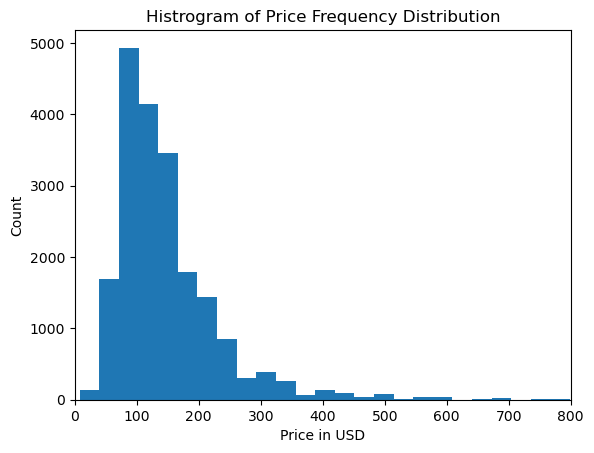

In [6]:
### 3.1 Price Distribution
a1 = plt.subplots()
plt.hist(listings["price"], bins = 25, density = False)
plt.xlabel("Price in USD")
plt.ylabel("Count")
plt.title("Histrogram of Price Frequency Distribution")
plt.grid(False)
plt.xlim(0, 800)

plt.show()

In [7]:
# Avoiding inf values
listings["price" == 0] = 1e-5

listings["price"] = np.log(listings["price"])

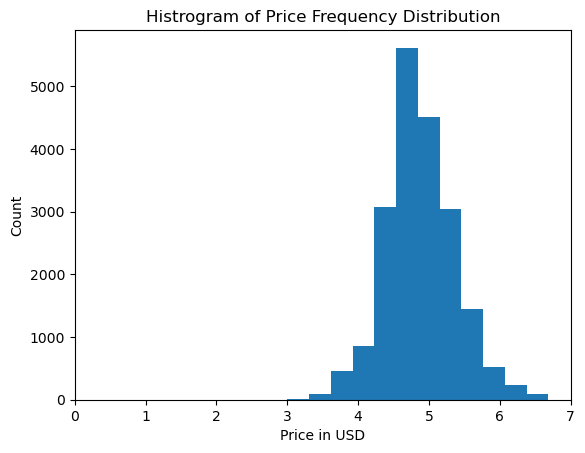

In [8]:
### 3.1 Price Distribution
a1 = plt.subplots()
plt.hist(listings["price"], bins = 15, density = False)
plt.xlabel("Price in USD")
plt.ylabel("Count")
plt.title("Histrogram of Price Frequency Distribution")
plt.grid(False)
plt.xlim(0, 7)

plt.show()

### 3.2 Spatial Distribution of Price

In [9]:
listings_prices = listings[["nhood","price"]].groupby("nhood").mean("price").reset_index()
listings_prices.head(1)

,nhood,price
0,Bijlmer-Centrum,4.35539


In [10]:
# Spatially joining neighbourhood to each listing
map_prices = pd.merge(nhoods, listings_prices, on = "nhood", how = "inner")

map_prices.head(1)

,nhood,geometry,price
0,Bijlmer-Oost,"MULTIPOLYGON Z (((4.99167 52.32444 0.00000, 4....",4.403268


In [11]:
map_prices.hvplot(
    crs = nhoods.crs,
    geo = True,
    frame_width = 500,
    frame_height = 500,
    cmap = "viridis",
    c = "price",
    dynamic = False
)

/Users/nohman/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/nohman/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/nohman/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


:Polygons   [Longitude,Latitude]   (price)

In [40]:
listings["price"].mean()

4.86960988521158

In [39]:
listings["price"].std()

0.4873054417608917

In [101]:
std_nhood = listings.groupby("nhood").agg(np.std, ddof = 0).rename(columns = {"price" : "std_price"})["std_price"]
mean_nhood = listings.groupby("nhood").mean("price")["price"]

/Users/nohman/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The default value of numeric_only in GeoDataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/nohman/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The default value of numeric_only in GeoDataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/nohman/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/numpy/core/f

In [97]:
std_nhood = std_nhood.to_frame().reset_index()
mean_nhood = mean_nhood.to_frame().reset_index()

In [106]:
concatted = pd.concat([std_nhood, mean_nhood], axis = 1)[["nhood", "std_price", "price"]]
concatted["low"] = np.exp(concatted["price"] - concatted["std_price"])
concatted["high"] = np.exp(concatted["price"] + concatted["std_price"])
concatted.head(21)



,nhood,nhood,std_price,price,low,high
0,Bijlmer-Centrum,Bijlmer-Centrum,0.519000,4.355390,46.357830,130.894243
1,Bijlmer-Oost,Bijlmer-Oost,0.610778,4.403268,44.366742,150.512379
2,Bos en Lommer,Bos en Lommer,0.401156,4.673648,71.700095,159.940760
3,Buitenveldert - Zuidas,Buitenveldert - Zuidas,0.514958,4.811480,73.443911,205.704019
4,Centrum-Oost,Centrum-Oost,0.500947,5.069800,96.433475,262.630281
5,Centrum-West,Centrum-West,0.487176,5.085596,99.327225,263.162690
6,De Aker - Nieuw Sloten,De Aker - Nieuw Sloten,0.559780,4.669417,60.924574,186.642906
7,De Baarsjes - Oud-West,De Baarsjes - Oud-West,0.433552,4.853467,83.089232,197.753176
8,De Pijp - Rivierenbuurt,De Pijp - Rivierenbuurt,0.454975,4.916452,86.615382,215.169627
9,Gaasperdam - Driemond,Gaasperdam - Driemond,0.518131,4.383336,47.713028,134.486927


### 3.1 Sentiment Analysis of Reviews

In [12]:
# Converting column type to string
reviews = reviews[reviews["comments"].notna()]

reviews["comments"] = reviews["comments"].astype(str)
reviews.head(1)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...


In [13]:
# Selecting the first five comments for each listing
reviews = reviews.groupby("listing_id").head(5)

reviews.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...


In [14]:
# Trimming the comments
reviews_trim = reviews.loc[reviews["comments"] != ""]
descriptions = reviews_trim["comments"].str.strip().tolist()

In [16]:
# Setting up pipieline for sentiment analysis
from transformers import pipeline

model = "bhadresh-savani/distilbert-base-uncased-emotion"

emotion_classifier = pipeline(
    task = "text-classification", 
    model = model, 
    top_k = None,  
    tokenizer = model,  
    truncation = True,  
)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [17]:
emotion_scores = emotion_classifier(descriptions)

In [18]:
# Defining sentiments and adding prediction to data frame
emotion = pd.DataFrame(
    [{d["label"]: d["score"] for d in dd} for dd in emotion_scores]).assign(text = descriptions)

emotion_labels = ["anger", "fear", "sadness", "joy", "surprise", "love"]

emotion[emotion_labels].idxmax(axis=1)

emotion['prediction'] = emotion[emotion_labels].idxmax(axis=1)


In [19]:
reviews_trim = reviews_trim.reset_index()

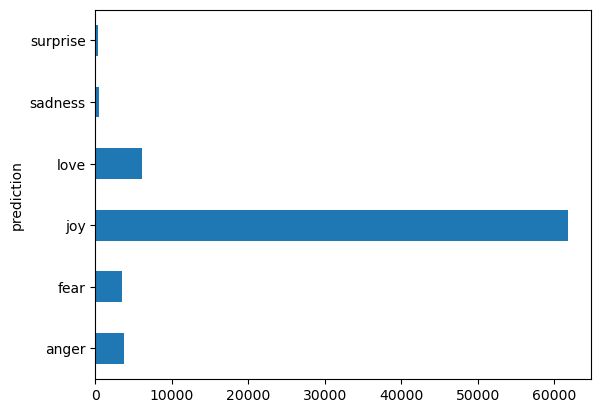

In [20]:
emotion.groupby("prediction").size().plot(kind='barh');

In [21]:
# Adding results back to original data frame
data_conc = pd.concat([reviews_trim, emotion], axis = 1)
data_conc.head(1)

,index,listing_id,id,date,reviewer_id,reviewer_name,comments,joy,sadness,anger,fear,love,surprise,text,prediction
0,0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...,0.611862,0.337563,0.0334,0.011916,0.004273,0.000986,Daniel is really cool. The place was nice and ...,joy


In [22]:
# Defining a scoring system for each emotion
def scoring_system(prediction):
  if prediction in ["joy", "love"]:
    return 1
  else:
    return -10

data_conc["score"] = data_conc["prediction"].apply(scoring_system)

data_conc.head(1)

,index,listing_id,id,date,reviewer_id,reviewer_name,comments,joy,sadness,anger,fear,love,surprise,text,prediction,score
0,0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...,0.611862,0.337563,0.0334,0.011916,0.004273,0.000986,Daniel is really cool. The place was nice and ...,joy,1


In [23]:
# Calculating sentinment score for each listing
data_conc = data_conc.groupby("listing_id").mean("score").reset_index()
data_conc.head(1)

,listing_id,index,id,reviewer_id,joy,sadness,anger,fear,love,surprise,score
0,2818,2.0,2179.8,13532.0,0.919928,0.067708,0.006881,0.002481,0.002663,0.000339,1.0


In [24]:
listings = listings.rename(columns = {"id":"listing_id"})

In [26]:
# Joining all data sets together
listings = pd.merge(listings, data_conc, on = "listing_id", how = "inner")
listings.head(1)

,listing_id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,scrape_id,last_scraped,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,calendar_last_scraped,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,geometry,index_right,nhood,False,index,id,reviewer_id,joy,sadness,anger,fear,love,surprise,score
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,4.077537,3,248,2018-11-28,2.1,1,44,https://www.airbnb.com/rooms/2818,20181206172549,2018-12-06,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",From week 38 to week 47 maintenance work to th...,The neighbourhood is well served by 24 hours p...,NaN,NaN,Please: - Leave your shoes in the entrance - ...,NaN,NaN,https://a0.muscache.com/im/pictures/10272854/8...,NaN,https://www.airbnb.com/users/show/3159,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,NaN,Amsterdam,North Holland,NaN,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,f,Apartment,2,1.5,1.0,2.0,Real Bed,"{Internet,Wifi,""Paid parking off premises"",""Bu...",NaN,NaN,"$1,500.00",$100.00,$50.00,1,$20.00,15,today,t,17,44,44,2018-12-06,2009-03-30,97.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,{Amsterdam},t,f,strict_14_with_grace_period,f,f,POINT (4.94142 52.36575),6.0,Oostelijk Havengebied - Indische Buurt,0.00001,2.0,2179.8,13532.0,0.919928,0.067708,0.006881,0.002481,0.002663,0.000339,1.0


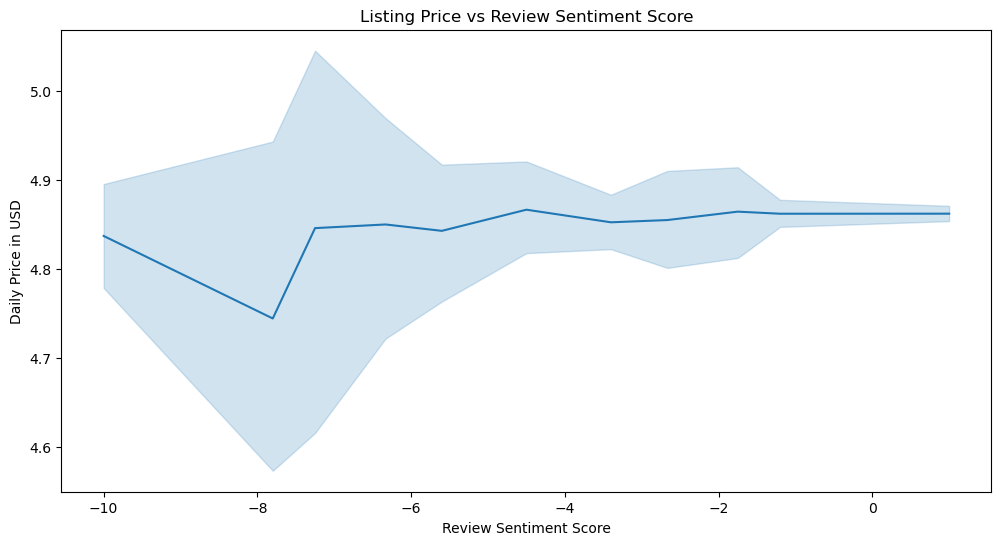

In [27]:
plt.figure(figsize = (12, 6))
sns.lineplot(data = listings, x = "score", y = "price")

plt.title("Listing Price vs Review Sentiment Score")
plt.xlabel("Review Sentiment Score")
plt.ylabel("Daily Price in USD")
plt.grid(False)
plt.show()

### 3.2 Price vs Number of Reviews

In [28]:
listings_plt = pd.read_csv("data/listings_py.csv")

In [29]:
listings_plt = listings_plt[["price", "reviews_per_month"]]
listings_plt.head(1)

,price,reviews_per_month
0,59,2.1


In [30]:
x = listings_plt["price"]
y = listings_plt["reviews_per_month"]

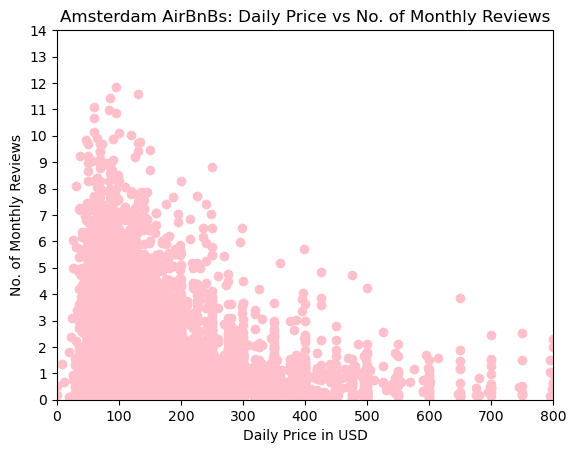

In [32]:
fig, ax = plt.subplots()

x = x 
y = y 
ax.scatter(x, y, c='pink')
ax.set_title('Amsterdam AirBnBs: Daily Price vs No. of Monthly Reviews')
ax.set_xlabel('Daily Price in USD')
ax.set_ylabel('No. of Monthly Reviews')
plt.ylim(0,14)
plt.yticks(range(0,15))
plt.xlim(0,800)
plt.show()

### 3.3 Price vs Number of Included Guests

In [33]:
listings_sbn = listings.groupby("guests_included").mean("price").reset_index()[["guests_included", "price"]]
listings_sbn.head(1)

,guests_included,price
0,1,4.304118


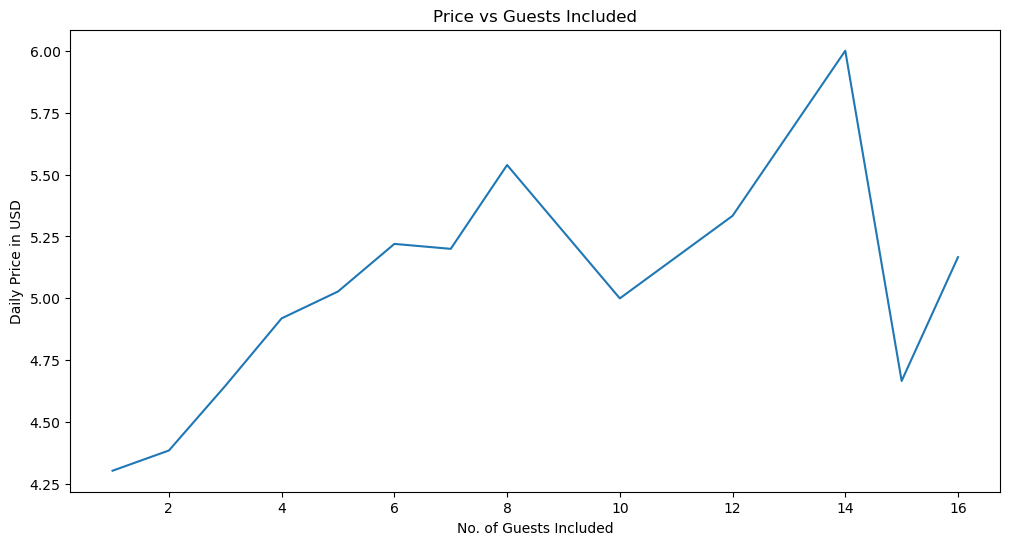

In [34]:
plt.figure(figsize = (12, 6))
sns.lineplot(data = listings_sbn, x = "guests_included", y = "price")

plt.title("Price vs Guests Included")
plt.xlabel("No. of Guests Included")
plt.ylabel("Daily Price in USD")
plt.grid(False)
plt.show()

### 3.4 Price vs Number of Bathrooms

In [35]:
listings_alt_1 = listings.groupby("bathrooms").mean("price").reset_index()[["bathrooms", "price"]]
listings_alt_1.head(1)

,bathrooms,price
0,0.0,4.0


In [36]:
alt.Chart(listings_alt_1).mark_point().encode(x =alt.X("bathrooms", title = "No. of Bathrooms", scale = alt.Scale(domain = [0,15])), y = alt.Y("price", title = "Daily Price in USD")).properties(
    width = 300,
    height = 300,
    title = "Number of Bathrooms vs Daily Price",
)



alt.Chart(...)

### 3.5 Price vs Number of Bedrooms

In [37]:
listings_alt_2 = listings.groupby("beds").mean("price").reset_index()[["beds", "price"]]
listings_alt_2 = listings_alt_2[(listings_alt_2["price"] < 700) & (listings_alt_2["beds"] < 14)]


In [38]:
alt.Chart(listings_alt_2).mark_point().encode(x =alt.X("beds", title = "No. of Beds", scale = alt.Scale(domain = [0,15])), y = alt.Y("price", title = "Daily Price in USD")).properties(
    width = 300,
    height = 300,
    title = "Number of Beds vs Daily Price",
)

alt.Chart(...)

In [28]:
listings = listings[listings["bathrooms"] < 6]

### 3.6 Price vs Property Type

In [30]:
prop_type = listings.groupby("property_type").agg({"price" :"mean", "id":"count"}).rename(columns = {"id" : "count"}).reset_index()
prop_type = prop_type.sort_values(ascending = False, by = "price")
prop_type.head(20)

,property_type,price,count
0,Aparthotel,5.426766,3
24,Serviced apartment,5.325990,53
27,Villa,5.217532,28
18,Hotel,5.172728,6
20,Houseboat,5.152728,204
21,Loft,5.136587,353
4,Boat,5.084830,344
26,Townhouse,5.036800,565
10,Castle,5.010635,1
2,Barn,4.963882,4


### 3.7 K-Nearest Listings

In [32]:
# Get the X/Y
# Neighbors
from sklearn.neighbors import NearestNeighbors

def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    
    Note: this works with both Point() and Polygon() objects.
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

listingsXY = get_xy_from_geometry(listings.to_crs(nhoods.crs))

# Run the k nearest algorithm on data set itself
nbrs = NearestNeighbors(n_neighbors = 6)
nbrs.fit(listingsXY)

distances, indices = nbrs.kneighbors(listingsXY)

/var/folders/lk/32gs42ns5pg1sx_wsf080w080000gn/T/ipykernel_8301/1336528089.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x = df.geometry.centroid.x
/var/folders/lk/32gs42ns5pg1sx_wsf080w080000gn/T/ipykernel_8301/1336528089.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y = df.geometry.centroid.y


In [33]:
# the total trips for the stations from original data frame
listings_price = listings["price"].values

In [34]:
listings_price

array([4.07753744, 5.07517382, 4.38202663, ..., 3.68887945, 5.35658627,
       3.68887945])

In [35]:
# get the trips for the 5 nearest neighbors (ignoring first match)
neighboring_listings = listings_price[indices[:, 1:]]

In [36]:
neighboring_listings

array([[4.38202663, 4.31748811, 4.07753744, 5.01063529, 6.08677473],
       [5.27299956, 4.70048037, 4.77068462, 4.49980967, 4.69134788],
       [5.01063529, 5.39362755, 4.94164242, 4.17438727, 4.94164242],
       ...,
       [5.01063529, 4.69134788, 4.90527478, 4.48863637, 4.09434456],
       [5.47227067, 5.01063529, 5.70378247, 6.2126061 , 5.52146092],
       [5.18738581, 4.47733681, 4.60517019, 4.97673374, 4.58496748]])

In [37]:
# Add to features
listings["lagged_price"] = neighboring_listings.mean(axis = 1)

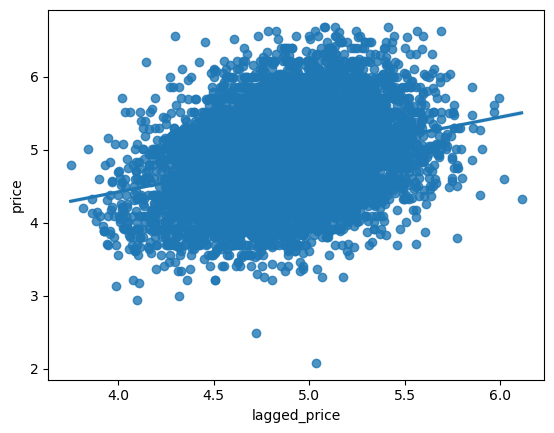

In [38]:
sns.regplot(x = listings["lagged_price"], y = listings["price"]);

# 4 Regression Model

In [39]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

In [40]:
# Preparing data set for regression
listings= listings.rename(str, axis = "columns")


In [41]:
variables = ["reviews_per_month", 
             "guests_included", 
             "bathrooms", 
             "beds", 
             "bedrooms", 
             "zipcode", 
             "accommodates", 
             "cleaning_fee", 
             "security_deposit", 
             "neighbourhood",
             "property_type",
             "cleaning_fee",
             "security_deposit",
             "score",
             "lagged_price"]

for i in variables:
 listings = listings[listings[i].notna()]

listings.shape

(11569, 112)

In [42]:
# Converting dollar columns to float
dollar_cols = ["cleaning_fee", "security_deposit", "extra_people", "monthly_price"]

for i in dollar_cols:
 listings[i] = listings[i].replace("[\$,]", "", regex = True).astype(float)

# Numerical columns
num_cols = ["reviews_per_month", 
            "guests_included", 
            "bathrooms", 
            "beds", 
            "bedrooms",
            "accommodates", 
            "cleaning_fee", 
            "security_deposit", 
            "extra_people",
            "score",
            "lagged_price"]

# Categorical columns
cat_cols = ["zipcode", "property_type", "room_type", "neighbourhood"]

# check feature importance, include distirbuto of erros, and a discussion, 




/var/folders/lk/32gs42ns5pg1sx_wsf080w080000gn/T/ipykernel_8301/3898089319.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(listings[cols].corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax = ax);


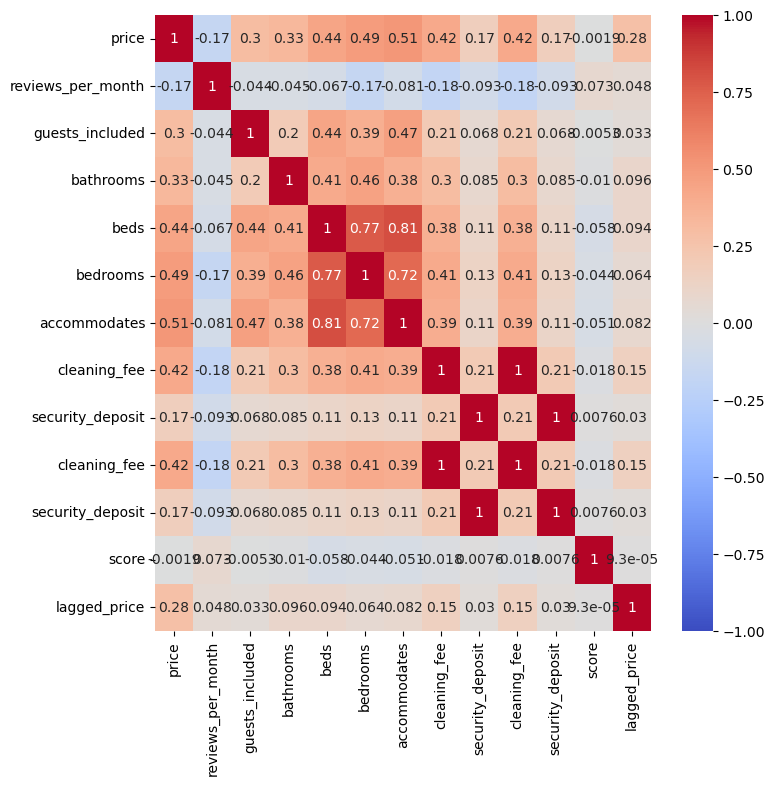

In [43]:
cols = [    "price",
            "reviews_per_month", 
             "guests_included", 
             "bathrooms", 
             "beds", 
             "bedrooms", 
             "zipcode", 
             "accommodates", 
             "cleaning_fee", 
             "security_deposit", 
             "property_type",
             "security_deposit",
             "score",
             "lagged_price"
    
]

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(listings[cols].corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax = ax);

In [44]:
# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [45]:
# Initialize the pipeline
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [46]:
# Split the data 70/30
train_set, test_set = train_test_split(listings, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["price"])
y_test = np.log(test_set["price"])

In [47]:
# Fit the training set
# REMINDER: use the training dataframe objects here rather than numpy array
pipe.fit(train_set, y_train);

In [48]:
# What's the test score?
# REMINDER: use the test dataframe rather than numpy array
pipe.score(test_set, y_test)

0.5035661554706758

# 5 Regression Evaluation and Discussion

In [49]:
def plot_feature_importances(pipeline, num_cols, transformer, top=20, **kwargs):
    """
    Utility function to plot the feature importances from the input
    random forest regressor.

    Parameters
    ----------
    pipeline :
        the pipeline object
    num_cols :
        list of the numerical columns
    transformer :
        the transformer preprocessing step
    top : optional
        the number of importances to plot
    **kwargs : optional
        extra keywords passed to the hvplot function
    """
    # The one-hot step
    ohe = transformer.named_transformers_["cat"]

    # One column for each category type!
    ohe_cols = ohe.get_feature_names_out()

    # Full list of columns is numerical + one-hot
    features = num_cols + list(ohe_cols)

    # The regressor
    regressor = pipeline["randomforestregressor"]

    # Create the dataframe with importances
    importance = pd.DataFrame(
        {"Feature": features, "Importance": regressor.feature_importances_}
    )

    # Sort importance in descending order and get the top
    importance = importance.sort_values("Importance", ascending=False).iloc[:top]

    # Plot
    return importance.hvplot.barh(
        x="Feature", y="Importance", flip_yaxis=True, **kwargs
    )

In [50]:
plot_feature_importances(pipe, num_cols, transformer, top = 30, height = 500)

:Bars   [Feature]   (Importance)